In [1]:
%matplotlib inline
import glob
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

import utils #personal helper functions

Frist lets load the images.

In [2]:
test_images = glob.glob(pathname='test_images/*')
chessboard_images = glob.glob(pathname='camera_cal/*')

### Camera Calibration

#### 1. Briefly state how you computed the camera matrix and distortion coefficients. Provide an example of a distortion corrected calibration image.

The code for this step is contained in the first code cell of the IPython notebook located in "./examples/example.ipynb" (or in lines # through # of the file called `some_file.py`).  

I start by preparing "object points", which will be the (x, y, z) coordinates of the chessboard corners in the world. Here I am assuming the chessboard is fixed on the (x, y) plane at z=0, such that the object points are the same for each calibration image.  Thus, `objp` is just a replicated array of coordinates, and `objpoints` will be appended with a copy of it every time I successfully detect all chessboard corners in a test image.  `imgpoints` will be appended with the (x, y) pixel position of each of the corners in the image plane with each successful chessboard detection.  

I then used the output `objpoints` and `imgpoints` to compute the camera calibration and distortion coefficients using the `cv2.calibrateCamera()` function.  I applied this distortion correction to the test image using the `cv2.undistort()` function and obtained this result: 

![alt text][image1]


## Calibrate Camera

In [3]:
def get_undistort_function(chessboard_images, nx, ny):
    '''
    Accepts chessboard calibration images and the number of corners
    to find. 
    
    Returns calibrated undistort function to undistort images.
    '''

    objpoints = []
    imgpoints = []
    
    #Create grid for the object points
    objp = np.zeros((nx*ny,3), np.float32)
    objp[:, :2] = np.mgrid[0:nx, 0:ny].T.reshape(-1,2)
    
    for image_path in chessboard_images:
        
        # Find the chessboard corners
        img = cv2.imread(image_path)
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

        # If corners found add points to list
        if ret == True:
            imgpoints.append(corners)
            objpoints.append(objp)
            
    #calculate calibration transform
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

    #Create undistort function with the right transform variables
    def undistort(img):
        undistorted_img = cv2.undistort(img, mtx, dist, None, mtx)
        return undistorted_img

    #Return the preloaded undistort function.
    return undistort

undistort = get_undistort_function(chessboard_images, 9, 6)

## Undistort Image

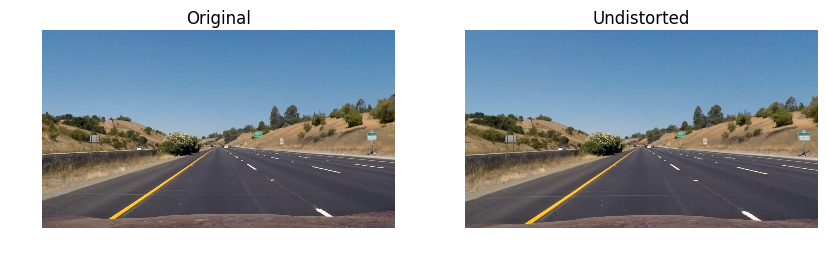

In [4]:
#Load the original image.
img_path = 'test_images/straight_lines1.jpg'
img = utils.imread_RGB(img_path)

img_ud = undistort(img)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.imshow(img)
plt.title('Original')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(img_ud)
plt.title('Undistorted')
plt.axis('off');

## Perspective Transform


In [151]:
img_height, img_width = img.shape[:2]
img_size = (img_width, img_height)

y_top = img_height/1.5
y_bottom = img_height
x_center = img_width/2
x_tl = x_center - .2 * x_center
x_tr = x_center + .2 * x_center
x_bl = x_center - .9 * x_center
x_br = x_center + .9 * x_center

src = np.float32([[x_bl,y_bottom],
                  [x_tl,y_top],
                  [x_tr,y_top],
                  [x_br,y_bottom]])

dst = np.float32([[0, img_height],
                  [0 ,0],
                  [img_width, 0],
                  [img_width,img_height]])

def get_birdseye_functions(src, dst, img_size):
    
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)

    def birdseye(img):
        return cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)

    def unbirdseye(img):
        return cv2.warpPerspective(img, Minv, img_size, flags=cv2.INTER_LINEAR)
    
    return birdseye, unbirdseye

birdseye, unbirdseye = get_birdseye_functions(src, dst, img_size)

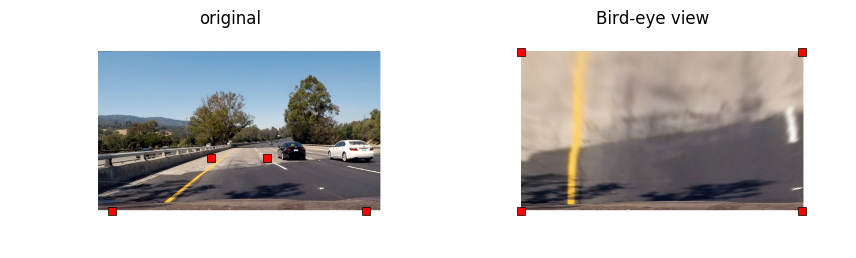

In [150]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.imshow(img,cmap='gray')
for i in range(4):
    plt.plot(src[i][0],src[i][1],'rs')
plt.title('original')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(birdseye(img),cmap='gray')
for i in range(4):
    plt.plot(dst[i][0],dst[i][1],'rs')
plt.title('Bird-eye view')
plt.axis('off');

### Thresholding



In [332]:
def abs_sobel_thresh(gray, orient='x', thresh=(0,255), sobel_kernel=3):
    thresh_max = thresh[1]
    thresh_min = thresh[0]
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # Return the result
    return binary_output

def gaussian_blur(img, kernel=5):
    # Apply Gaussian Blur
    blur = cv2.GaussianBlur(img,(kernel,kernel),0)
    return blur


Good link to color spaces: https://en.wikipedia.org/wiki/HSL_and_HSV

#### 2. Describe how (and identify where in your code) you used color transforms, gradients or other methods to create a thresholded binary image.  Provide an example of a binary image result.

I used a combination of color and gradient thresholds to generate a binary image (thresholding steps at lines # through # in `another_file.py`).  Here's an example of my output for this step.  (note: this is not actually from one of the test images)


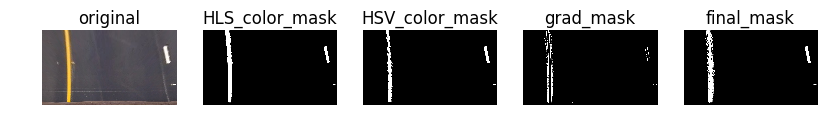

In [345]:


def get_HLS_color_mask(img_HLS):

    # color channel thresholds
    white_hls_min  = np.array([ 0,   210,   0])
    white_hls_max = np.array([ 255,  255, 100])

    yellow_hls_min  = np.array([ 10,  90,  100])
    yellow_hls_max = np.array([ 60, 255, 255])

    yellow_hsl_mask =  cv2.inRange(img_HLS, yellow_hls_min, yellow_hls_max)
    white_hsl_mask =  cv2.inRange(img_HLS, white_hls_min, white_hls_max)

    mask = np.zeros_like(white_hsl_mask)
    mask[(white_hsl_mask > 0) | (yellow_hsl_mask>0)] = 1
    return mask


def get_HSV_color_mask(img_HSV):

    # color channel thresholds
    
    img_HLS = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    # color channel thresholds
    white_hsv_min  = np.array([ 0,   0,   210])
    white_hsv_max = np.array([ 255,  30, 255])

    yellow_hsv_min  = np.array([ 20,  100,  100])
    yellow_hsv_max = np.array([ 60, 255, 255])

    yellow_hsv_mask = cv2.inRange(img_HSV, yellow_hsv_min, yellow_hsv_max)
    white_hsv_mask = cv2.inRange(img_HSV, white_hsv_min, white_hsv_max)

    mask = np.zeros_like(white_hsv_mask)
    mask[(white_hsv_mask > 0) | (yellow_hsv_mask>0)] = 1
    return mask


def get_grad_mask(img_HSV, img_HLS):
    value_gray = img_HSV[:,:,2]
    value_grad = abs_sobel_thresh(value_gray, orient='x', sobel_kernel=5, thresh=(30, 240))

    sat_gray = img_HLS[:,:,2]
    sat_grad = abs_sobel_thresh(sat_gray, orient='x', sobel_kernel=7, thresh=(30, 240))

    light_gray = img_HLS[:,:,1]
    light_grad = abs_sobel_thresh(light_gray, orient='x', sobel_kernel=7, thresh=(30, 240))
    light_grady = abs_sobel_thresh(light_gray, orient='y', sobel_kernel=7, thresh=(30, 240))


    grad_sum = value_grad + sat_grad + light_grad
    ret, grad_mask = cv2.threshold(grad_sum,1.9,255,cv2.THRESH_BINARY)
    return grad_mask

img = utils.imread_RGB('test_images/test2.jpg')
img = birdseye(img)

img_HLS = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
img_HSV = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
HLS_color_mask = get_HLS_color_mask(img_HLS)
HSV_color_mask = get_HSV_color_mask(img_HSV)
grad_mask = get_grad_mask(img_HLS, img_HSV)

final_sum = HLS_color_mask + HSV_color_mask + grad_mask
ret, final_mask = cv2.threshold(final_sum,.9,255,cv2.THRESH_BINARY)

imgs =   [img, HLS_color_mask, HSV_color_mask, grad_mask, final_mask]
labels = ['original', 'HLS_color_mask', 'HSV_color_mask', 'grad_mask', 'final_mask']
cmap = 'gray'
utils.show_imgs(imgs, labels, cmap)

## Writeup Template

### You can use this file as a template for your writeup if you want to submit it as a markdown file, but feel free to use some other method and submit a pdf if you prefer.

---

**Advanced Lane Finding Project**

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

[//]: # (Image References)

[image1]: ./examples/undistort_output.png "Undistorted"
[image2]: ./test_images/test1.jpg "Road Transformed"
[image3]: ./examples/binary_combo_example.jpg "Binary Example"
[image4]: ./examples/warped_straight_lines.jpg "Warp Example"
[image5]: ./examples/color_fit_lines.jpg "Fit Visual"
[image6]: ./examples/example_output.jpg "Output"
[video1]: ./project_video.mp4 "Video"

## [Rubric](https://review.udacity.com/#!/rubrics/571/view) Points

### Here I will consider the rubric points individually and describe how I addressed each point in my implementation.  

---




### Pipeline (single images)




#### 4. Describe how (and identify where in your code) you identified lane-line pixels and fit their positions with a polynomial?

Then I did some other stuff and fit my lane lines with a 2nd order polynomial kinda like this:

![alt text][image5]

#### 5. Describe how (and identify where in your code) you calculated the radius of curvature of the lane and the position of the vehicle with respect to center.

I did this in lines # through # in my code in `my_other_file.py`

#### 6. Provide an example image of your result plotted back down onto the road such that the lane area is identified clearly.

I implemented this step in lines # through # in my code in `yet_another_file.py` in the function `map_lane()`.  Here is an example of my result on a test image:

![alt text][image6]

---

### Pipeline (video)

#### 1. Provide a link to your final video output.  Your pipeline should perform reasonably well on the entire project video (wobbly lines are ok but no catastrophic failures that would cause the car to drive off the road!).

Here's a [link to my video result](./project_video.mp4)

---

### Discussion

#### 1. Briefly discuss any problems / issues you faced in your implementation of this project.  Where will your pipeline likely fail?  What could you do to make it more robust?

Here I'll talk about the approach I took, what techniques I used, what worked and why, where the pipeline might fail and how I might improve it if I were going to pursue this project further.  
